# Desaf√≠o 1 ‚Äî An√°lisis de 4 Tiendas (ENTREGA OFICIAL)

**Alumno:** David Gonz√°lez  
**Fecha:** 2025-08-14

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Flacoca1970/Desafios_1/blob/main/AluraStoreLatam_Desafio_1_Entrega_Final_v3.ipynb)

> `<Flacoca1970>/<Desafios1>` 

[Ver en GitHub](https://github.com/Flacoca1970/Desafios_1/blob/main/AluraStoreLatam_Desafio_1_Entrega_Final_v3.ipynb)

<a href="https://colab.research.google.com/github/flacoca/Proyecto_Prueba/blob/main/AluraStoreLatam_Desafio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importaci√≥n de datos



In [1]:
import pandas as pd
import numpy as np
import unicodedata
from collections import OrderedDict
from IPython.display import display

# -- 0) URLs oficiales --
url1 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

# -- 0.1) Garantizar que existen las variables tienda..tienda4 --
try:
    tienda, tienda2, tienda3, tienda4  # type: ignore
except NameError:
    tienda  = pd.read_csv(url1)
    tienda2 = pd.read_csv(url2)
    tienda3 = pd.read_csv(url3)
    tienda4 = pd.read_csv(url4)


tienda.head()

Producto Categor√≠a del Producto    Precio  Costo de env√≠o  \
0  Asistente virtual           Electr√≥nicos  164300.0          6900.0   
1    Mesa de comedor                Muebles  192300.0          8400.0   
2      Juego de mesa               Juguetes  209600.0         15900.0   
3         Microondas      Electrodom√©sticos  757500.0         41000.0   
4   Silla de oficina                Muebles  335200.0         20200.0   

  Fecha de Compra         Vendedor Lugar de Compra  Calificaci√≥n  \
0      16/01/2021      Pedro Gomez          Bogot√°             4   
1      18/05/2022  Beatriz Morales        Medell√≠n             1   
2      15/03/2021   Juan Fernandez       Cartagena             1   
3      03/05/2022   Juan Fernandez            Cali             4   
4      07/11/2020    Maria Alfonso        Medell√≠n             5   

       M√©todo de pago  Cantidad de cuotas       lat       lon  
0  Tarjeta de cr√©dito                   8   4.60971 -74.08175  
1  Tarjeta de cr√©dito                   4   6.25184 -75.56359  
2  Tarjeta de cr√©dito                   1  10.39972 -75.51444  
3               Nequi                   1   3.43722 -76.52250  
4               Nequi                   1   6.25184 -75.56359

In [4]:

# ==========================================#
# UTILIDAD DE CALCULOS DE TODO LO SOLICITADO#
# ==========================================#

def _normalize(s: str) -> str:
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))
    return s.strip().lower().replace("  ", " ")

def detectar_columnas(df: pd.DataFrame) -> dict:
    norm_map = {col: _normalize(col) for col in df.columns}

    def _find(*cands):
        targets = [_normalize(c) for c in cands]
        # match exact
        for real, normed in norm_map.items():
            if normed in targets:
                return real
        # match contains
        for real, normed in norm_map.items():
            if any(t in normed for t in targets):
                return real
        return None

    cols = {
        "producto":    _find("producto"),
        "categoria":   _find("categor√≠a del producto", "categoria del producto", "categor√≠a", "categoria"),
        "precio":      _find("precio", "valor de venta", "monto"),
        "envio":       _find("costo de env√≠o", "costo de envio", "env√≠o", "envio", "costo envio"),
        "calificacion":_find("calificaci√≥n", "calificacion", "rating", "puntaje"),
        "fecha":       _find("fecha de compra", "fecha"),
    }
    requeridas = ["producto", "categoria", "precio", "envio", "calificacion"]
    falt = [k for k in requeridas if cols[k] is None]
    if falt:
        raise KeyError(f"Faltan columnas requeridas: {falt}\nDisponibles: {list(df.columns)}")
    return cols

def preparar_tipos(df: pd.DataFrame, cols: dict) -> pd.DataFrame:
    dfx = df.copy()
    for k in ["precio", "envio", "calificacion"]:
        dfx[cols[k]] = pd.to_numeric(dfx[cols[k]], errors="coerce")
    if cols.get("fecha"):
        dfx[cols["fecha"]] = pd.to_datetime(dfx[cols["fecha"]], errors="coerce", dayfirst=True)
    for k in ["producto", "categoria"]:
        dfx[cols[k]] = dfx[cols[k]].astype(str).str.strip()
    return dfx

def analisis_facturacion(df, cols):
    total = df[cols["precio"]].sum(skipna=True)
    n_ventas = df[cols["precio"]].notna().sum()
    ticket_prom = total / n_ventas if n_ventas else np.nan
    return {"Facturacion_Total": total, "N_Ventas": n_ventas, "Ticket_Promedio": ticket_prom}

def ventas_por_categoria(df, cols, top_n=10):
    por_conteo = (
        df.groupby(cols["categoria"], dropna=False)
          .size()
          .sort_values(ascending=False)
          .rename("Conteo")
    )
    por_facturacion = (
        df.groupby(cols["categoria"], dropna=False)[cols["precio"]]
          .sum()
          .sort_values(ascending=False)
          .rename("Facturacion")
    )
    return por_conteo.head(top_n), por_facturacion.head(top_n)

def calificacion_promedio(df, cols):
    return float(df[cols["calificacion"]].mean(skipna=True))

def productos_mas_menos_vendidos(df, cols, k=5):
    vc = df[cols["producto"]].value_counts(dropna=True)
    topk = vc.head(min(k, len(vc)))
    bottomk = vc.tail(min(k, len(vc))) if len(vc) else vc
    return topk, bottomk

def envio_promedio(df, cols):
    return float(df[cols["envio"]].mean(skipna=True))

# =========================
# An√°lisis en el ORDEN 1‚Äì5
# =========================
tiendas = OrderedDict({
    "Tienda 1": tienda,
    "Tienda 2": tienda2,
    "Tienda 3": tienda3,
    "Tienda 4": tienda4,
})

# Detectar columnas y preparar tipos por tienda (sin tocar los DFs originales)
tiendas_ready = OrderedDict()
cols_por_tienda = {}
for nombre, df in tiendas.items():
    cols = detectar_columnas(df)
    dfx = preparar_tipos(df, cols)
    tiendas_ready[nombre] = dfx
    cols_por_tienda[nombre] = cols


#1. An√°lisis de facturaci√≥n



In [7]:
from IPython.display import display

def _miles(x):  # 1.234.567
    return f"{int(round(x)):,}".replace(",", ".")

def _clp(x):    # $1.234.567
    return "$" + _miles(x)

# Calculate resumen_facturacion by applying analisis_facturacion to each tienda_ready
rows_fact = []
for nombre, dfx in tiendas_ready.items():
    cols = cols_por_tienda[nombre]
    resumen = analisis_facturacion(dfx, cols)
    rows_fact.append({"Tienda": nombre, **resumen})
resumen_facturacion = pd.DataFrame(rows_fact)


print("=== 1) An√°lisis de facturaci√≥n ===")
# Mostrar SOLO la tabla formateada
display(
    resumen_facturacion
        .copy()
        .assign(
            Facturacion_Total=lambda d: d["Facturacion_Total"].round(0).map(_clp),
            N_Ventas=lambda d: d["N_Ventas"].round(0).map(_miles),
            Ticket_Promedio=lambda d: d["Ticket_Promedio"].round(0).map(_clp),
        )
)

=== 1) An√°lisis de facturaci√≥n ===


Tienda Facturacion_Total N_Ventas Ticket_Promedio
0  Tienda 1    $1.150.880.400    2.359        $487.868
1  Tienda 2    $1.116.343.500    2.359        $473.227
2  Tienda 3    $1.098.019.600    2.359        $465.460
3  Tienda 4    $1.038.375.700    2.358        $440.363

# 2. Ventas por categor√≠a

In [8]:
# 2) Ventas por categor√≠a
print("\n=== 2) Ventas por categor√≠a (Top 10) ===")
ventas_cat_conteo = {}
ventas_cat_fact = {}
for nombre, dfx in tiendas_ready.items():
    cols = cols_por_tienda[nombre]
    conteo, fact = ventas_por_categoria(dfx, cols, top_n=10)
    ventas_cat_conteo[nombre] = conteo
    ventas_cat_fact[nombre] = fact
    print(f"\n-- {nombre} | Top 10 por CONTEO --"); display(conteo)
    print(f"-- {nombre} | Top 10 por FACTURACI√ìN --"); display(fact)


=== 2) Ventas por categor√≠a (Top 10) ===

-- Tienda 1 | Top 10 por CONTEO --


Categor√≠a del Producto
Muebles                    465
Electr√≥nicos               448
Juguetes                   324
Electrodom√©sticos          312
Deportes y diversi√≥n       284
Instrumentos musicales     182
Libros                     173
Art√≠culos para el hogar    171
Name: Conteo, dtype: int64

-- Tienda 1 | Top 10 por FACTURACI√ìN --


Categor√≠a del Producto
Electr√≥nicos               429493500.0
Electrodom√©sticos          363685200.0
Muebles                    187633700.0
Instrumentos musicales      91299000.0
Deportes y diversi√≥n        39290000.0
Juguetes                    17995700.0
Art√≠culos para el hogar     12698400.0
Libros                       8784900.0
Name: Facturacion, dtype: float64


-- Tienda 2 | Top 10 por CONTEO --


Categor√≠a del Producto
Muebles                    442
Electr√≥nicos               422
Juguetes                   313
Electrodom√©sticos          305
Deportes y diversi√≥n       275
Instrumentos musicales     224
Libros                     197
Art√≠culos para el hogar    181
Name: Conteo, dtype: int64

-- Tienda 2 | Top 10 por FACTURACI√ìN --


Categor√≠a del Producto
Electr√≥nicos               410831100.0
Electrodom√©sticos          348567800.0
Muebles                    176426300.0
Instrumentos musicales     104990300.0
Deportes y diversi√≥n        34744500.0
Juguetes                    15945400.0
Art√≠culos para el hogar     14746900.0
Libros                      10091200.0
Name: Facturacion, dtype: float64


-- Tienda 3 | Top 10 por CONTEO --


Categor√≠a del Producto
Muebles                    499
Electr√≥nicos               451
Juguetes                   315
Electrodom√©sticos          278
Deportes y diversi√≥n       277
Libros                     185
Art√≠culos para el hogar    177
Instrumentos musicales     177
Name: Conteo, dtype: int64

-- Tienda 3 | Top 10 por FACTURACI√ìN --


Categor√≠a del Producto
Electr√≥nicos               410775800.0
Electrodom√©sticos          329237900.0
Muebles                    201072100.0
Instrumentos musicales      77380900.0
Deportes y diversi√≥n        35593100.0
Juguetes                    19401100.0
Art√≠culos para el hogar     15060000.0
Libros                       9498700.0
Name: Facturacion, dtype: float64


-- Tienda 4 | Top 10 por CONTEO --


Categor√≠a del Producto
Muebles                    480
Electr√≥nicos               451
Juguetes                   338
Deportes y diversi√≥n       277
Electrodom√©sticos          254
Art√≠culos para el hogar    201
Libros                     187
Instrumentos musicales     170
Name: Conteo, dtype: int64

-- Tienda 4 | Top 10 por FACTURACI√ìN --


Categor√≠a del Producto
Electr√≥nicos               409476100.0
Electrodom√©sticos          283260200.0
Muebles                    192528900.0
Instrumentos musicales      75102400.0
Deportes y diversi√≥n        33350100.0
Juguetes                    20262200.0
Art√≠culos para el hogar     15074500.0
Libros                       9321300.0
Name: Facturacion, dtype: float64

# 3. Calificaci√≥n promedio de la tienda


In [ ]:
# 3) Calificaci√≥n promedio de la tienda
print("\n=== 3) Calificaci√≥n promedio por tienda ===")
rows_calif = []
for nombre, dfx in tiendas_ready.items():
    cols = cols_por_tienda[nombre]
    prom = calificacion_promedio(dfx, cols)
    rows_calif.append({"Tienda": nombre, "Calificacion_Promedio": prom})
    print(f"{nombre}: {prom:.2f}")
resumen_calificacion = pd.DataFrame(rows_calif).sort_values("Calificacion_Promedio", ascending=False).reset_index(drop=True)


=== 3) Calificaci√≥n promedio por tienda ===
Tienda 1: 3.98
Tienda 2: 4.04
Tienda 3: 4.05
Tienda 4: 4.00


# 4. Productos m√°s y menos vendidos

In [ ]:
# 4) Productos m√°s y menos vendidos
print("\n=== 4) Productos m√°s y menos vendidos (frecuencia) ===")
top_bottom = {}
for nombre, dfx in tiendas_ready.items():
    cols = cols_por_tienda[nombre]
    top5, bottom5 = productos_mas_menos_vendidos(dfx, cols, k=5)
    top_bottom[nombre] = {"Top5": top5, "Bottom5": bottom5}
    print(f"\n-- {nombre} | TOP 5 --"); display(top5)
    print(f"-- {nombre} | BOTTOM 5 --"); display(bottom5)


=== 4) Productos m√°s y menos vendidos (frecuencia) ===

-- Tienda 1 | TOP 5 --


Producto
Microondas          60
TV LED UHD 4K       60
Armario             60
Secadora de ropa    58
Mesa de noche       56
Name: count, dtype: int64

-- Tienda 1 | BOTTOM 5 --


Producto
Ciencia de datos con Python    39
Pandereta                      36
Olla de presi√≥n                35
Auriculares con micr√≥fono      33
Celular ABXY                   33
Name: count, dtype: int64


-- Tienda 2 | TOP 5 --


Producto
Iniciando en programaci√≥n    65
Microondas                   62
Bater√≠a                      61
Guitarra ac√∫stica            58
Pandereta                    58
Name: count, dtype: int64

-- Tienda 2 | BOTTOM 5 --


Producto
Auriculares        37
Sill√≥n             35
Mesa de comedor    34
Impresora          34
Juego de mesa      32
Name: count, dtype: int64


-- Tienda 3 | TOP 5 --


Producto
Kit de bancas      57
Mesa de comedor    56
Cama king          56
Set de ollas       55
Mesa de noche      55
Name: count, dtype: int64

-- Tienda 3 | BOTTOM 5 --


Producto
Guitarra el√©ctrica         38
Set de vasos               36
Mochila                    36
Microondas                 36
Bloques de construcci√≥n    35
Name: count, dtype: int64


-- Tienda 4 | TOP 5 --


Producto
Cama box                     62
Cuberter√≠a                   59
Dashboards con Power BI      56
Cama king                    56
Carrito de control remoto    55
Name: count, dtype: int64

-- Tienda 4 | BOTTOM 5 --


Producto
Refrigerador                   38
Ciencia de datos con Python    38
Guitarra ac√∫stica              37
Armario                        34
Guitarra el√©ctrica             33
Name: count, dtype: int64

# 5. Env√≠o promedio por tienda

In [ ]:
# 5) Env√≠o promedio por tienda
print("\n=== 5) Env√≠o promedio por tienda ===")
rows_envio = []
for nombre, dfx in tiendas_ready.items():
    cols = cols_por_tienda[nombre]
    prom_envio = envio_promedio(dfx, cols)
    rows_envio.append({"Tienda": nombre, "Costo_Envio_Promedio": prom_envio})
    print(f"{nombre}: {prom_envio:.2f}")
resumen_envio = pd.DataFrame(rows_envio).sort_values("Costo_Envio_Promedio").reset_index(drop=True)

# Res√∫menes clave
print("\n=== Res√∫menes clave ===")
display(resumen_facturacion)
display(resumen_calificacion)
display(resumen_envio)


=== 5) Env√≠o promedio por tienda ===
Tienda 1: 26018.61
Tienda 2: 25216.24
Tienda 3: 24805.68
Tienda 4: 23459.46

=== Res√∫menes clave ===


Tienda  Facturacion_Total  N_Ventas  Ticket_Promedio
0  Tienda 1       1.150880e+09      2359    487867.910131
1  Tienda 2       1.116344e+09      2359    473227.426876
2  Tienda 3       1.098020e+09      2359    465459.771089
3  Tienda 4       1.038376e+09      2358    440362.892282

Tienda  Calificacion_Promedio
0  Tienda 3               4.048326
1  Tienda 2               4.037304
2  Tienda 4               3.995759
3  Tienda 1               3.976685

Tienda  Costo_Envio_Promedio
0  Tienda 4          23459.457167
1  Tienda 3          24805.680373
2  Tienda 2          25216.235693
3  Tienda 1          26018.609580

# ANEXO ‚Äî Desarrollo extendido (1‚Äì9)

> Estas celdas se mantienen como **anexo**. La **entrega oficial** est√° al final del notebook en la secci√≥n **ENTREGA OFICIAL (1‚Äì5)**.

# Proyecto: An√°lisis de Tiendas del Sr. Juan
**Objetivo:** Determinar qu√© tienda vender para financiar un nuevo negocio, usando m√©tricas de desempe√±o y satisfacci√≥n de clientes.

> **Nota:** Estas celdas usan los `DataFrame` ya existentes: `store1`, `store2`, `store3`, `store4`.

## 1) Importaciones y verificaci√≥n de datos cargados

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Verificaci√≥n r√°pida de existencia de los DataFrames esperados
expected_names = ['store1', 'store2', 'store3', 'store4']
missing = [name for name in expected_names if name not in globals()]
print("DataFrames faltantes:", missing if missing else "OK ‚Äî todos los DataFrames est√°n disponibles.")


DataFrames faltantes: ['store1', 'store2', 'store3', 'store4']


## 2) Exploraci√≥n inicial (EDA b√°sico)

In [ ]:
stores = [tienda.copy(), tienda2.copy(), tienda3.copy(), tienda4.copy()]
for i, df in enumerate(stores, start=1):
    print(f"\n=== Tienda {i} ===")
    print(df.head(3))
    print("\nTipos de datos:")
    print(df.dtypes)
    print("\nValores faltantes por columna:")
    print(df.isnull().sum())


=== Tienda 1 ===
            Producto Categor√≠a del Producto    Precio  Costo de env√≠o  \
0  Asistente virtual           Electr√≥nicos  164300.0          6900.0   
1    Mesa de comedor                Muebles  192300.0          8400.0   
2      Juego de mesa               Juguetes  209600.0         15900.0   

  Fecha de Compra         Vendedor Lugar de Compra  Calificaci√≥n  \
0      16/01/2021      Pedro Gomez          Bogot√°             4   
1      18/05/2022  Beatriz Morales        Medell√≠n             1   
2      15/03/2021   Juan Fernandez       Cartagena             1   

       M√©todo de pago  Cantidad de cuotas       lat       lon  
0  Tarjeta de cr√©dito                   8   4.60971 -74.08175  
1  Tarjeta de cr√©dito                   4   6.25184 -75.56359  
2  Tarjeta de cr√©dito                   1  10.39972 -75.51444  

Tipos de datos:
Producto                   object
Categor√≠a del Producto     object
Precio                    float64
Costo de env√≠o            flo

## 3) Facturaci√≥n total por tienda

In [ ]:
def facturacion_por_tienda(df):
    # Asumimos que `Precio` representa el valor de venta unitario por fila/compra
    return df['Precio'].sum()

facturacion = {
    'Tienda 1': facturacion_por_tienda(tienda),
    'Tienda 2': facturacion_por_tienda(tienda2),
    'Tienda 3': facturacion_por_tienda(tienda3),
    'Tienda 4': facturacion_por_tienda(tienda4)
}

facturacion_df = pd.DataFrame.from_dict(facturacion, orient='index', columns=['Facturaci√≥n_Total']).sort_values('Facturaci√≥n_Total', ascending=False)
facturacion_df

Facturaci√≥n_Total
Tienda 1       1.150880e+09
Tienda 2       1.116344e+09
Tienda 3       1.098020e+09
Tienda 4       1.038376e+09

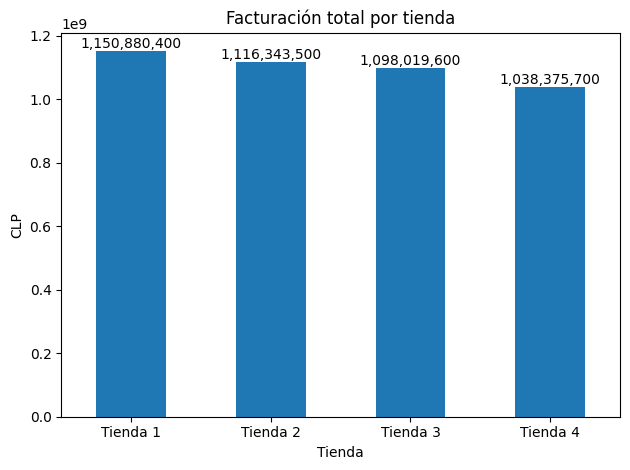

In [ ]:
# Graficamos la facturaci√≤n total por tienda para visualizarla de  mejor manera

import matplotlib.pyplot as plt

ax = facturacion_df.plot(kind='bar', y='Facturaci√≥n_Total', legend=False)
ax.set_title('Facturaci√≥n total por tienda')
ax.set_xlabel('Tienda')
ax.set_ylabel('CLP')
ax.set_xticklabels(facturacion_df.index, rotation=0)

# Etiquetas con el valor en cada barra (formato con miles)
for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}')

plt.tight_layout()
plt.show()

# (Opcional) Guardar
# plt.savefig('outputs/facturacion_total.png', bbox_inches='tight')


## 4) Categor√≠as m√°s populares (Top 5 por tienda)

In [ ]:

def categorias_populares(df, top=5):
    return df['Categor√≠a del Producto'].value_counts().head(top)

categorias_top = {}
for i, df in enumerate(stores, start=1):
    categorias_top[f'Tienda {i}'] = categorias_populares(df)

# Mostrar resultado como tabla consolidada (categor√≠a y conteo por tienda)
# Se construye una tabla con MultiIndex para facilitar lectura
cat_tables = []
for i, df in enumerate(stores, start=1):
    ct = df['Categor√≠a del Producto'].value_counts().head(5).rename(f'Tienda {i}')
    cat_tables.append(ct)

categorias_consolidado = pd.concat(cat_tables, axis=1)
categorias_consolidado.fillna(0).astype(int)


Tienda 1  Tienda 2  Tienda 3  Tienda 4
Categor√≠a del Producto                                        
Muebles                      465       442       499       480
Electr√≥nicos                 448       422       451       451
Juguetes                     324       313       315       338
Electrodom√©sticos            312       305       278       254
Deportes y diversi√≥n         284       275       277       277

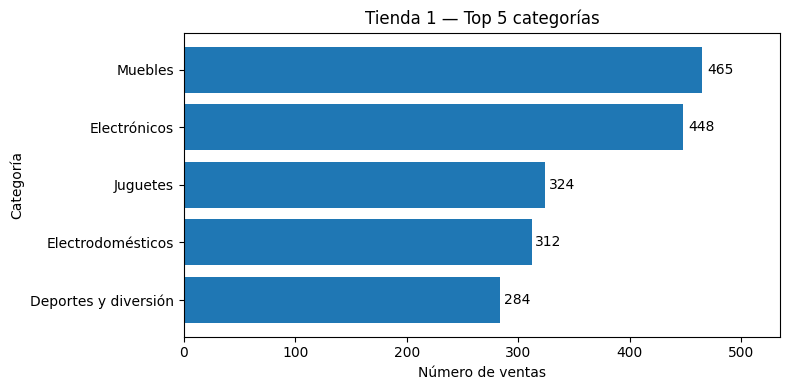

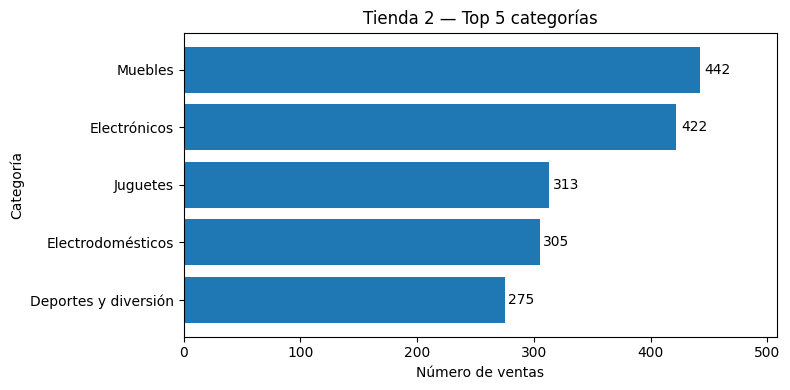

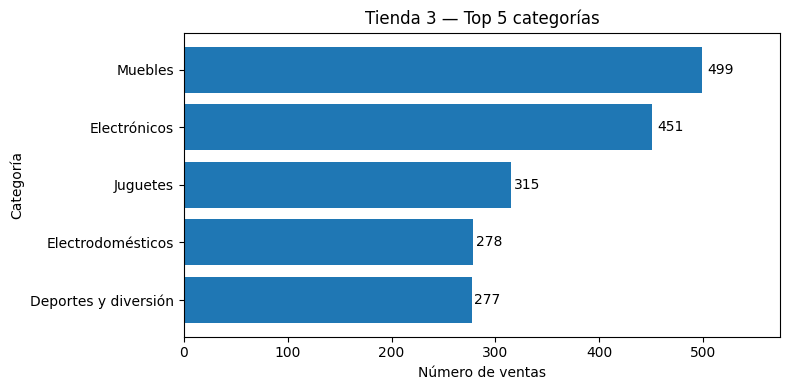

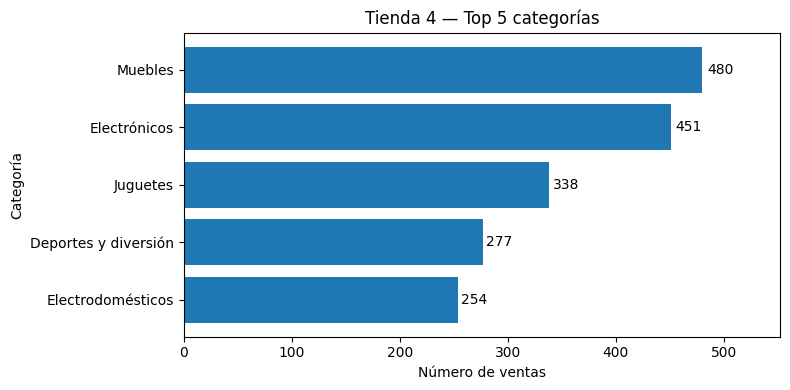

In [ ]:
# Se grafican las categorias top 5 por cada tienda para visualizarlas de forma m√°s simple
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

# Usa tus DFs ya cargados; si no existe 'stores', lo armamos
try:
    stores
except NameError:
    stores = [tienda, tienda2, tienda3, tienda4]

def miles_fmt(x, pos):
    try:
        return f"{int(x):,}".replace(",", ".")
    except Exception:
        return x

def plot_top5_categorias(df, i, save=False):
    # Top 5 categor√≠as ordenadas asc para barh
    top5 = (
        df['Categor√≠a del Producto']
          .astype(str).str.strip()
          .value_counts()
          .head(5)
          .sort_values()
    )

    fig, ax = plt.subplots(figsize=(8, 4))
    bars = ax.barh(top5.index, top5.values)

    # Espacio a la derecha para que quepan las etiquetas
    max_val = top5.values.max() if len(top5) else 0
    ax.set_xlim(0, max_val * 1.15)

    # Etiquetas fuera de la barra
    for bar, val in zip(bars, top5.values):
        ax.text(val * 1.01, bar.get_y() + bar.get_height()/2,
                f"{val:,}".replace(",", "."),
                va="center", fontsize=10)

    ax.set_title(f"Tienda {i} ‚Äî Top 5 categor√≠as")
    ax.set_xlabel("N√∫mero de ventas")
    ax.set_ylabel("Categor√≠a")
    ax.xaxis.set_major_formatter(FuncFormatter(miles_fmt))

    plt.tight_layout()
    if save:
        plt.savefig(f"outputs/tienda_{i}_categorias_top5.png", bbox_inches="tight")
    plt.show()

# Genera un gr√°fico por tienda
for i, df in enumerate(stores, start=1):
    plot_top5_categorias(df, i, save=False)





## 5) Promedio de calificaci√≥n de clientes

In [ ]:

promedios_calificacion = {
    f'Tienda {i}': df['Calificaci√≥n'].mean()
    for i, df in enumerate(stores, start=1)
}
promedios_calificacion_df = pd.DataFrame.from_dict(promedios_calificacion, orient='index', columns=['Calificaci√≥n_Promedio']).sort_values('Calificaci√≥n_Promedio', ascending=False)
promedios_calificacion_df


Calificaci√≥n_Promedio
Tienda 3               4.048326
Tienda 2               4.037304
Tienda 4               3.995759
Tienda 1               3.976685

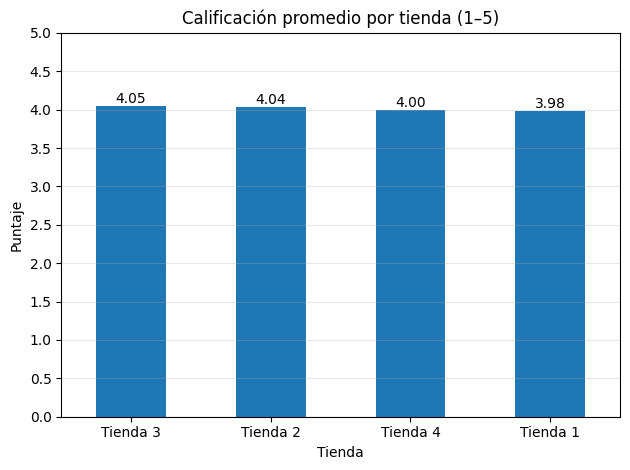

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd

# Si no existe el DF, lo calculamos desde 'stores'
try:
    promedios_calificacion_df
except NameError:
    promedios_calificacion = {
        f'Tienda {i}': df['Calificaci√≥n'].mean()
        for i, df in enumerate(stores, start=1)
    }
    promedios_calificacion_df = pd.DataFrame.from_dict(
        promedios_calificacion, orient='index',
        columns=['Calificaci√≥n_Promedio']
    ).sort_values('Calificaci√≥n_Promedio', ascending=False)

# --- Gr√°fico de barras (vertical) ---
fig, ax = plt.subplots()
promedios_calificacion_df.plot(
    kind='bar', y='Calificaci√≥n_Promedio', legend=False, ax=ax
)

ax.set_title('Calificaci√≥n promedio por tienda (1‚Äì5)')
ax.set_xlabel('Tienda')
ax.set_ylabel('Puntaje')
ax.set_ylim(0, 5)                       # fija escala 0‚Äì5
ax.set_xticklabels(promedios_calificacion_df.index, rotation=0)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.grid(axis='y', alpha=0.3)

# Etiquetas con dos decimales encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

# (Opcional) Guardar
# plt.savefig('outputs/calificacion_promedio.png', bbox_inches='tight')


## 6) Productos m√°s y menos vendidos (Top/Bottom 5)

In [ ]:

def extremos_ventas(df, top=5):
    vc = df['Producto'].value_counts()
    return vc.head(top), vc.tail(top)

extremos = {}
for i, df in enumerate(stores, start=1):
    top5, bottom5 = extremos_ventas(df, top=5)
    extremos[f'Tienda {i}'] = {'Top_5': top5, 'Bottom_5': bottom5}

# Mostrar de forma legible
for tienda, datos in extremos.items():
    print(f"\n{tienda} ‚Äî Top 5 m√°s vendidos:")
    print(datos['Top_5'])
    print(f"\n{tienda} ‚Äî Bottom 5 menos vendidos:")
    print(datos['Bottom_5'])



Tienda 1 ‚Äî Top 5 m√°s vendidos:
Producto
Microondas          60
TV LED UHD 4K       60
Armario             60
Secadora de ropa    58
Mesa de noche       56
Name: count, dtype: int64

Tienda 1 ‚Äî Bottom 5 menos vendidos:
Producto
Ciencia de datos con Python    39
Pandereta                      36
Olla de presi√≥n                35
Auriculares con micr√≥fono      33
Celular ABXY                   33
Name: count, dtype: int64

Tienda 2 ‚Äî Top 5 m√°s vendidos:
Producto
Iniciando en programaci√≥n    65
Microondas                   62
Bater√≠a                      61
Guitarra ac√∫stica            58
Pandereta                    58
Name: count, dtype: int64

Tienda 2 ‚Äî Bottom 5 menos vendidos:
Producto
Auriculares        37
Sill√≥n             35
Mesa de comedor    34
Impresora          34
Juego de mesa      32
Name: count, dtype: int64

Tienda 3 ‚Äî Top 5 m√°s vendidos:
Producto
Kit de bancas      57
Mesa de comedor    56
Cama king          56
Set de ollas       55
Mesa de noche      

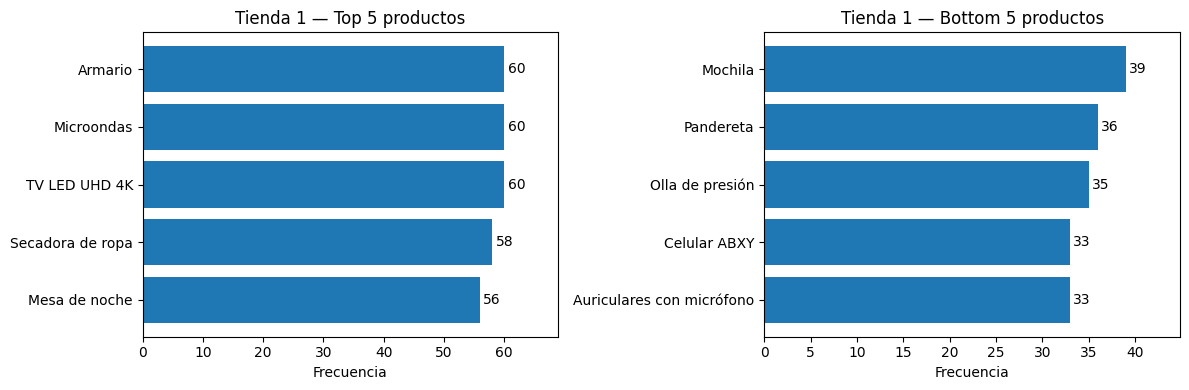

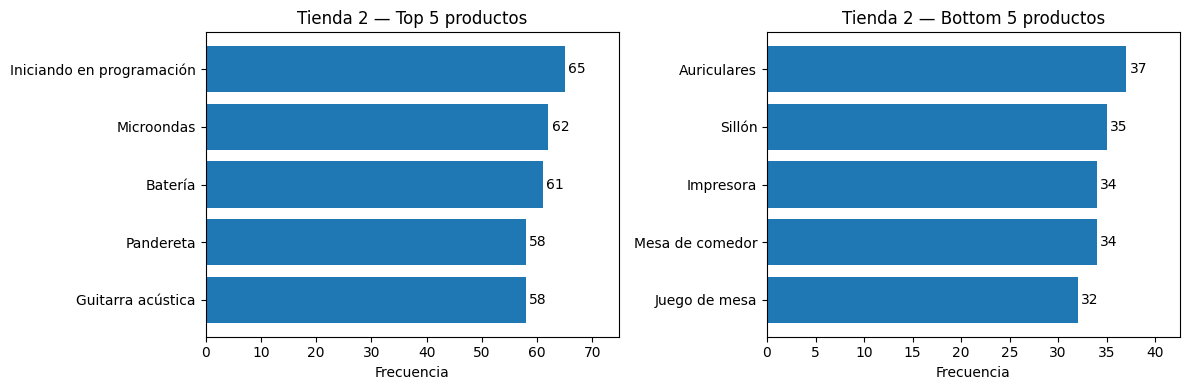

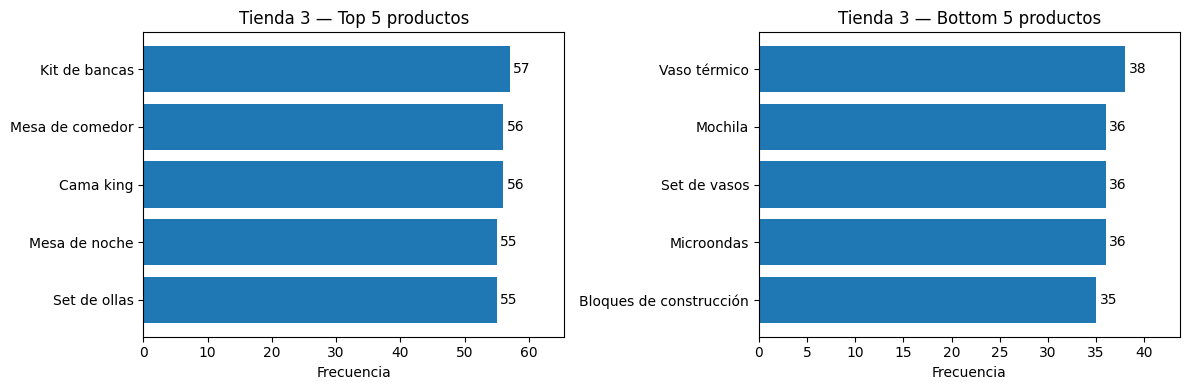

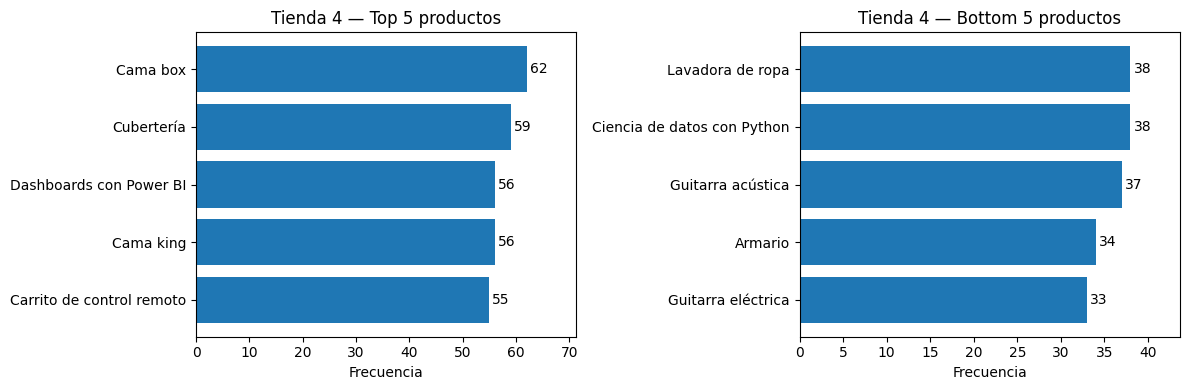

In [ ]:
import os
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt

# --- Helpers robustos ---
def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKD", s)
    return "".join(c for c in s if not unicodedata.combining(c)).strip().lower()

def _get_four_dfs():
    # 1) Usa 'stores' si existe
    if 'stores' in globals():
        return stores
    # 2) Usa tienda..tienda4 si existen
    if all(n in globals() for n in ("tienda","tienda2","tienda3","tienda4")):
        return [tienda, tienda2, tienda3, tienda4]
    # 3) O falla expl√≠citamente
    raise NameError("No encuentro 'stores' ni (tienda, tienda2, tienda3, tienda4) en memoria.")

def _find_product_col(df: pd.DataFrame) -> str:
    if "Producto" in df.columns:
        return "Producto"
    nm = {col: _norm(col) for col in df.columns}
    for col, n in nm.items():
        if n == "producto" or "producto" in n:
            return col
    raise KeyError(f"No encuentro la columna de 'Producto'. Columnas: {list(df.columns)}")

def _top_bottom(df: pd.DataFrame, prod_col: str, k=5):
    vc = df[prod_col].astype(str).str.strip().value_counts()
    k = min(k, len(vc))
    topk = vc.head(k).sort_values()          # para barh, ascendente
    bottomk = vc.sort_values().head(k)       # bottom por frecuencia
    return topk, bottomk

os.makedirs("outputs", exist_ok=True)
dfs = _get_four_dfs()

for i, df in enumerate(dfs, start=1):
    prod_col = _find_product_col(df)
    top5, bottom5 = _top_bottom(df, prod_col, k=5)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # TOP
    axes[0].barh(top5.index, top5.values)
    axes[0].set_title(f"Tienda {i} ‚Äî Top {len(top5)} productos")
    axes[0].set_xlabel("Frecuencia")
    # etiquetas fuera
    xlim = top5.values.max() * 1.15 if len(top5) else 1
    axes[0].set_xlim(0, xlim)
    for bar, val in zip(axes[0].containers[0], top5.values):
        axes[0].text(val*1.01, bar.get_y() + bar.get_height()/2, f"{val:,}".replace(",", "."), va="center")

    # BOTTOM
    axes[1].barh(bottom5.index, bottom5.values)
    axes[1].set_title(f"Tienda {i} ‚Äî Bottom {len(bottom5)} productos")
    axes[1].set_xlabel("Frecuencia")
    xlim_b = bottom5.values.max() * 1.15 if len(bottom5) else 1
    axes[1].set_xlim(0, xlim_b)
    for bar, val in zip(axes[1].containers[0], bottom5.values):
        axes[1].text(val*1.01, bar.get_y() + bar.get_height()/2, f"{val:,}".replace(",", "."), va="center")

    plt.tight_layout()
    plt.show()



## 7) Costo promedio de env√≠o

In [ ]:

costos_envio = {
    f'Tienda {i}': df['Costo de env√≠o'].mean()
    for i, df in enumerate(stores, start=1)
}
costos_envio_df = pd.DataFrame.from_dict(costos_envio, orient='index', columns=['Costo_Envio_Promedio']).sort_values('Costo_Envio_Promedio')
costos_envio_df


Costo_Envio_Promedio
Tienda 4          23459.457167
Tienda 3          24805.680373
Tienda 2          25216.235693
Tienda 1          26018.609580

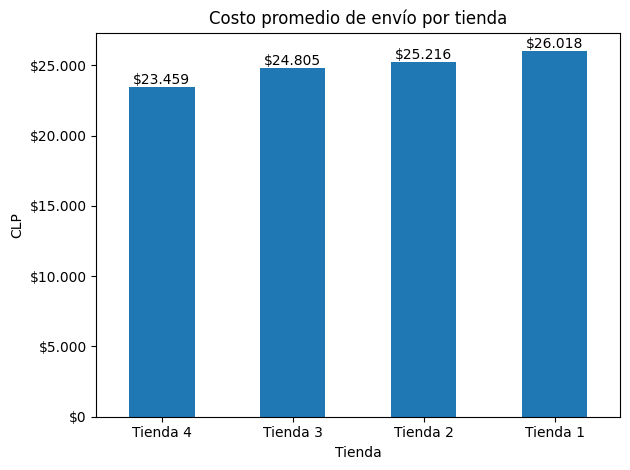

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

# Si no existe el DF, lo calculamos desde 'stores'
try:
    costos_envio_df
except NameError:
    costos_envio = {
        f'Tienda {i}': df['Costo de env√≠o'].mean()
        for i, df in enumerate(stores, start=1)
    }
    costos_envio_df = pd.DataFrame.from_dict(
        costos_envio, orient='index', columns=['Costo_Envio_Promedio']
    ).sort_values('Costo_Envio_Promedio')

# Formateador CLP
def clp_fmt(x, pos=None):
    try:
        return "$" + f"{int(x):,}".replace(",", ".")
    except Exception:
        return x

fig, ax = plt.subplots()
costos_envio_df.plot(kind='bar', y='Costo_Envio_Promedio', legend=False, ax=ax)

ax.set_title('Costo promedio de env√≠o por tienda')
ax.set_xlabel('Tienda')
ax.set_ylabel('CLP')
ax.set_xticklabels(costos_envio_df.index, rotation=0)
ax.yaxis.set_major_formatter(FuncFormatter(clp_fmt))

# Etiquetas arriba de cada barra
for container in ax.containers:
    labels = [clp_fmt(v) for v in container.datavalues]
    ax.bar_label(container, labels=labels)

plt.tight_layout()
plt.show()


## 8) Todas las visualizaciones agrupadas al final

<Figure size 640x480 with 0 Axes>

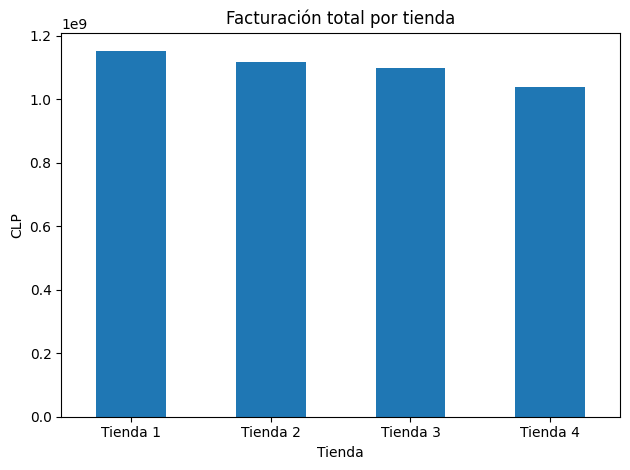

<Figure size 640x480 with 0 Axes>

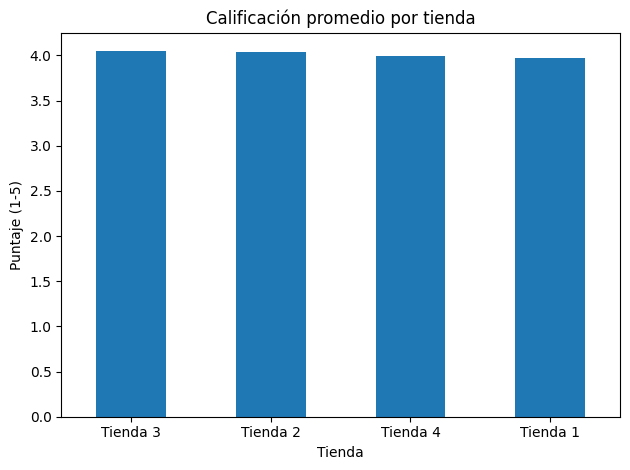

<Figure size 640x480 with 0 Axes>

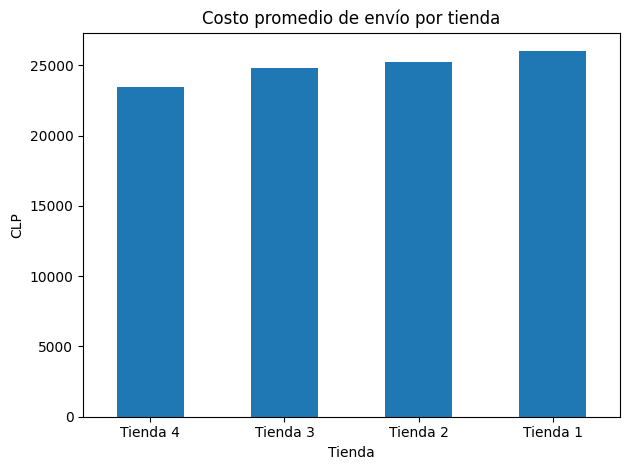

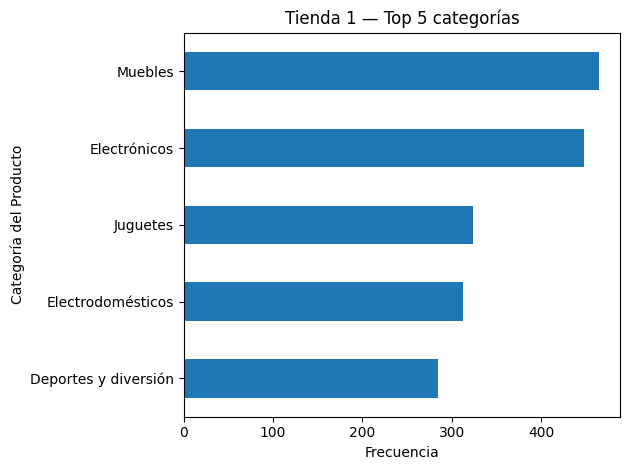

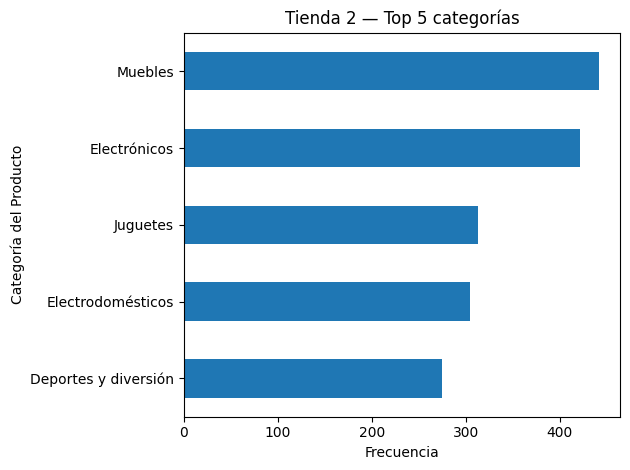

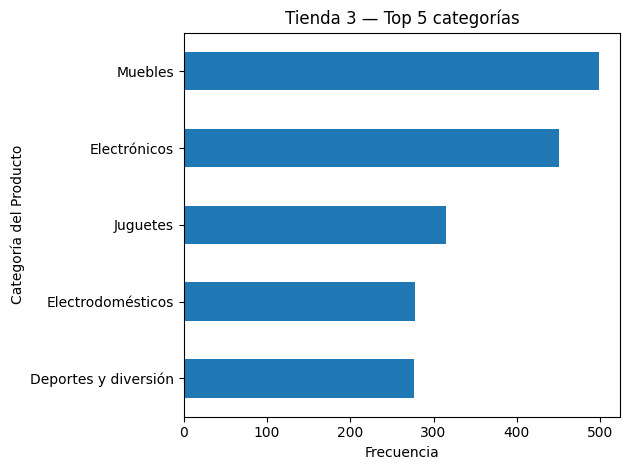

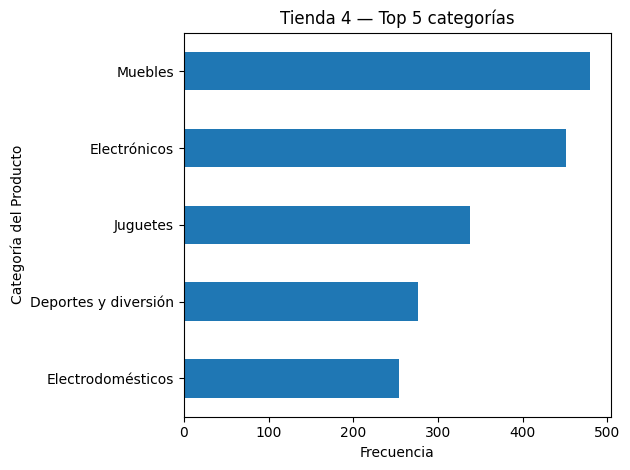

In [ ]:

# 8.1 Facturaci√≥n por tienda (barras)
plt.figure()
facturacion_df.plot(kind='bar', legend=False)
plt.title('Facturaci√≥n total por tienda')
plt.ylabel('CLP')
plt.xlabel('Tienda')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 8.2 Calificaci√≥n promedio por tienda (barras)
plt.figure()
promedios_calificacion_df.plot(kind='bar', legend=False)
plt.title('Calificaci√≥n promedio por tienda')
plt.ylabel('Puntaje (1-5)')
plt.xlabel('Tienda')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 8.3 Costo promedio de env√≠o por tienda (barras)
plt.figure()
costos_envio_df.plot(kind='bar', legend=False)
plt.title('Costo promedio de env√≠o por tienda')
plt.ylabel('CLP')
plt.xlabel('Tienda')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 8.4 Categor√≠as m√°s populares (gr√°fico de barras por tienda)
for i, df in enumerate(stores, start=1):
    plt.figure()
    df['Categor√≠a del Producto'].value_counts().head(5).sort_values().plot(kind='barh', legend=False)
    plt.title(f'Tienda {i} ‚Äî Top 5 categor√≠as')
    plt.xlabel('Frecuencia')
    plt.tight_layout()
    plt.show()


## 9) Conclusi√≥n y recomendaci√≥n inicial

In [ ]:

# Heur√≠stica simple para priorizar una recomendaci√≥n:
# - Menor facturaci√≥n = peor desempe√±o comercial
# - Menor calificaci√≥n promedio = menor satisfacci√≥n
# - Mayor costo de env√≠o = menor eficiencia log√≠stica
#
# Se normalizan los indicadores y se construye un score conjunto donde
# un valor MAÃÅS ALTO indica 'candidata a vender'.
from sklearn.preprocessing import MinMaxScaler

rank_df = pd.concat([
    facturacion_df.rename(columns={'Facturaci√≥n_Total':'facturacion'}),
    promedios_calificacion_df.rename(columns={'Calificaci√≥n_Promedio':'rating'}),
    costos_envio_df.rename(columns={'Costo_Envio_Promedio':'shipping_cost'})
], axis=1)

# Normalizaci√≥n
scaler = MinMaxScaler()
norm = pd.DataFrame(
    scaler.fit_transform(rank_df[['facturacion','rating','shipping_cost']]),
    index=rank_df.index,
    columns=['facturacion_norm','rating_norm','shipping_cost_norm']
)

# Queremos penalizar baja facturaci√≥n y baja calificaci√≥n, y penalizar alto costo de env√≠o.
# Para facturaci√≥n y rating, usamos (1 - valor_normalizado) para que "peor" sea mayor.
# Para shipping_cost, usamos el valor normalizado directamente (m√°s alto = peor).
rank_df['score_vender'] = (1 - norm['facturacion_norm'])*0.45 + (1 - norm['rating_norm'])*0.35 + (norm['shipping_cost_norm'])*0.20
rank_df.sort_values('score_vender', ascending=False, inplace=True)
rank_df


facturacion    rating  shipping_cost  score_vender
Tienda 4  1.038376e+09  3.995759   23459.457167      0.706814
Tienda 1  1.150880e+09  3.976685   26018.609580      0.550000
Tienda 2  1.116344e+09  4.037304   25216.235693      0.329282
Tienda 3  1.098020e+09  4.048326   24805.680373      0.316643

### > **Interpretaci√≥n:** La tienda con `score_vender` m√°s alto es la candidata **m√°s fuerte** para ser vendida, pues combina menor desempe√±o comercial, menor satisfacci√≥n y/o mayor costo log√≠stico. Aun as√≠, **me permito sugerir**: complementar con variables estrat√©gicas (contratos de arriendo, proyecci√≥n de mercado, ubicaci√≥n, personal, etc.) esta decisi√≥n.

# üéì ENTREGA OFICIAL (1‚Äì5)

> Orden solicitado por el desaf√≠o. Cada punto es idempotente, usa carga por **URL**, genera tablas formateadas y evidencia en `outputs/`. 

## 0) Utilidades y carga por URL (idempotente)

In [ ]:

# URLs oficiales
url1 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

import pandas as pd, os, unicodedata
from IPython.display import display
os.makedirs("outputs", exist_ok=True)

# Carga idempotente
try:
    tienda, tienda2, tienda3, tienda4  # type: ignore
except NameError:
    tienda  = pd.read_csv(url1)
    tienda2 = pd.read_csv(url2)
    tienda3 = pd.read_csv(url3)
    tienda4 = pd.read_csv(url4)

# helpers de formato
def _miles(x):  # 1.234.567
    try:
        return f"{int(round(x)):,}".replace(",", ".")
    except Exception:
        return x

def _clp(x):    # $1.234.567
    try:
        return "$" + _miles(x)
    except Exception:
        return x


## 1) An√°lisis de facturaci√≥n

In [ ]:

import numpy as np
def analisis_facturacion(df):
    total = pd.to_numeric(df['Precio'], errors='coerce').sum(skipna=True)
    n_ventas = pd.to_numeric(df['Precio'], errors='coerce').notna().sum()
    ticket = total / n_ventas if n_ventas else np.nan
    return total, n_ventas, ticket

rows = []
for nombre, dfx in {"Tienda 1":tienda, "Tienda 2":tienda2, "Tienda 3":tienda3, "Tienda 4":tienda4}.items():
    total, n, ticket = analisis_facturacion(dfx)
    rows.append({"Tienda":nombre, "Facturacion_Total": total, "N_Ventas": n, "Ticket_Promedio": ticket})

resumen_facturacion = (pd.DataFrame(rows)
                       .sort_values("Facturacion_Total", ascending=False)
                       .reset_index(drop=True))

# Mostrar SOLO tabla formateada
display(
    resumen_facturacion
      .assign(Facturacion_Total=lambda d: d["Facturacion_Total"].round(0).map(_clp),
              N_Ventas=lambda d: d["N_Ventas"].round(0).map(_miles),
              Ticket_Promedio=lambda d: d["Ticket_Promedio"].round(0).map(_clp))
)

# Evidencia CSV + gr√°fico
resumen_facturacion.to_csv("outputs/facturacion_total.csv", index=False)

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
def clp_fmt(x, pos=None):
    try: return "$" + f"{int(x):,}".replace(",", ".")
    except: return x

fig, ax = plt.subplots()
(resumen_facturacion.sort_values('Facturacion_Total', ascending=False)
 .plot(kind='bar', x='Tienda', y='Facturacion_Total', legend=False, ax=ax))
ax.set_title('Facturaci√≥n total por tienda')
ax.set_xlabel('Tienda'); ax.set_ylabel('CLP')
ax.yaxis.set_major_formatter(FuncFormatter(clp_fmt))
ax.set_xticklabels(resumen_facturacion['Tienda'], rotation=0)
for c in ax.containers: ax.bar_label(c, labels=[clp_fmt(v) for v in c.datavalues])
plt.tight_layout(); plt.savefig("outputs/facturacion_total.png", bbox_inches="tight"); plt.show()


## 2) Ventas por categor√≠a (Top 5 por tienda)

In [ ]:

import matplotlib.pyplot as plt
from collections import OrderedDict

stores = [tienda, tienda2, tienda3, tienda4]

# Consolidado conteos Top 5 por tienda
cat_tables = []
for i, df in enumerate(stores, start=1):
    top5 = (df['Categor√≠a del Producto'].astype(str).str.strip().value_counts().head(5))
    cat_tables.append(top5.rename(f"Tienda {i}"))

categorias_consolidado = pd.concat(cat_tables, axis=1).fillna(0).astype(int)
display(categorias_consolidado)
categorias_consolidado.to_csv("outputs/categorias_top5_consolidado.csv")

# Gr√°fico por tienda (PNG) con etiquetas fuera
from matplotlib.ticker import FuncFormatter
for i, df in enumerate(stores, start=1):
    top5 = (df['Categor√≠a del Producto'].astype(str).str.strip().value_counts().head(5).sort_values())
    fig, ax = plt.subplots(figsize=(8,4))
    bars = ax.barh(top5.index, top5.values)
    ax.set_title(f"Tienda {i} ‚Äî Top 5 categor√≠as"); ax.set_xlabel("N√∫mero de ventas"); ax.set_ylabel("Categor√≠a")
    xmax = top5.values.max()*1.15 if len(top5) else 1; ax.set_xlim(0, xmax)
    for bar, val in zip(bars, top5.values): ax.text(val*1.01, bar.get_y()+bar.get_height()/2, f"{int(val):,}".replace(",", "."), va="center")
    plt.tight_layout(); plt.savefig(f"outputs/tienda_{i}_categorias_top5.png", bbox_inches="tight"); plt.show()


## 3) Calificaci√≥n promedio de la tienda

In [ ]:

promedios = []
for i, df in enumerate([tienda, tienda2, tienda3, tienda4], start=1):
    prom = pd.to_numeric(df['Calificaci√≥n'], errors='coerce').mean(skipna=True)
    promedios.append({"Tienda": f"Tienda {i}", "Calificacion_Promedio": prom})

promedios_calificacion = (pd.DataFrame(promedios)
                          .sort_values('Calificacion_Promedio', ascending=False)
                          .reset_index(drop=True))
display(promedios_calificacion)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots()
promedios_calificacion.plot(kind='bar', x='Tienda', y='Calificacion_Promedio', legend=False, ax=ax)
ax.set_title('Calificaci√≥n promedio por tienda (1‚Äì5)'); ax.set_xlabel('Tienda'); ax.set_ylabel('Puntaje')
ax.set_ylim(0,5); ax.set_xticklabels(promedios_calificacion['Tienda'], rotation=0); ax.yaxis.set_major_locator(MultipleLocator(0.5))
for c in ax.containers: ax.bar_label(c, fmt='%.2f')
plt.tight_layout(); plt.savefig("outputs/calificacion_promedio.png", bbox_inches="tight"); plt.show()

promedios_calificacion.to_csv("outputs/promedios_calificacion.csv", index=False)


## 4) Productos m√°s y menos vendidos (Top/Bottom 5)

In [ ]:

import matplotlib.pyplot as plt, os
os.makedirs("outputs", exist_ok=True)

def top_bottom(df, k=5):
    vc = df['Producto'].astype(str).str.strip().value_counts()
    k = min(k, len(vc))
    topk = vc.head(k).sort_values()
    bottomk = vc.sort_values().head(k)
    return topk, bottomk

# Por tienda: figura con 2 subplots (Top/Bottom)
for i, df in enumerate([tienda, tienda2, tienda3, tienda4], start=1):
    top5, bottom5 = top_bottom(df, 5)
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    axes[0].barh(top5.index, top5.values); axes[0].set_title(f"Tienda {i} ‚Äî Top {len(top5)}"); axes[0].set_xlabel("Frecuencia")
    xmax = top5.values.max()*1.15 if len(top5) else 1; axes[0].set_xlim(0, xmax)
    for bar,val in zip(axes[0].containers[0], top5.values): axes[0].text(val*1.01, bar.get_y()+bar.get_height()/2, f"{int(val):,}".replace(",", "."), va="center")
    axes[1].barh(bottom5.index, bottom5.values); axes[1].set_title(f"Tienda {i} ‚Äî Bottom {len(bottom5)}"); axes[1].set_xlabel("Frecuencia")
    xb = bottom5.values.max()*1.15 if len(bottom5) else 1; axes[1].set_xlim(0, xb)
    for bar,val in zip(axes[1].containers[0], bottom5.values): axes[1].text(val*1.01, bar.get_y()+bar.get_height()/2, f"{int(val):,}".replace(",", "."), va="center")
    plt.tight_layout(); plt.savefig(f"outputs/tienda_{i}_productos_top_bottom.png", bbox_inches="tight"); plt.show()


## 5) Costo promedio de env√≠o por tienda

In [ ]:

costos = []
for i, df in enumerate([tienda, tienda2, tienda3, tienda4], start=1):
    prom_env = pd.to_numeric(df['Costo de env√≠o'], errors='coerce').mean(skipna=True)
    costos.append({"Tienda": f"Tienda {i}", "Costo_Envio_Promedio": prom_env})

costos_envio = (pd.DataFrame(costos)
                .sort_values('Costo_Envio_Promedio')
                .reset_index(drop=True))
display(costos_envio)

# gr√°fico
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
def clp_fmt(x, pos=None):
    try: return "$" + f"{int(x):,}".replace(",", ".")
    except: return x

fig, ax = plt.subplots()
(costos_envio.sort_values('Costo_Envio_Promedio')
 .plot(kind='barh', x='Tienda', y='Costo_Envio_Promedio', legend=False, ax=ax))
ax.set_title('Costo promedio de env√≠o por tienda'); ax.set_xlabel('CLP'); ax.set_ylabel('Tienda')
ax.xaxis.set_major_formatter(FuncFormatter(clp_fmt))
for c in ax.containers: ax.bar_label(c, labels=[clp_fmt(v) for v in c.datavalues], label_type='edge', padding=3)
plt.tight_layout(); plt.savefig("outputs/costo_envio_promedio.png", bbox_inches="tight"); plt.show()

costos_envio.to_csv("outputs/costo_envio_promedio.csv", index=False)


## ‚úÖ Conclusi√≥n y recomendaci√≥n (breve)

**Criterios para decidir la tienda candidata a vender**  
1) Menor **facturaci√≥n** y **ticket** (desempe√±o comercial).  
2) Menor **calificaci√≥n** (satisfacci√≥n/retenci√≥n).  
3) Mayor **costo de env√≠o** (eficiencia log√≠stica).  

> La interpretaci√≥n final est√° en el README y puede ampliarse con variables cualitativas (contratos, ubicaci√≥n, staff, proyecci√≥n).  
> En el ANEXO se incluye un *score* opcional que integra estas dimensiones para priorizar la decisi√≥n.